# Проект - Предсказание температуры стали

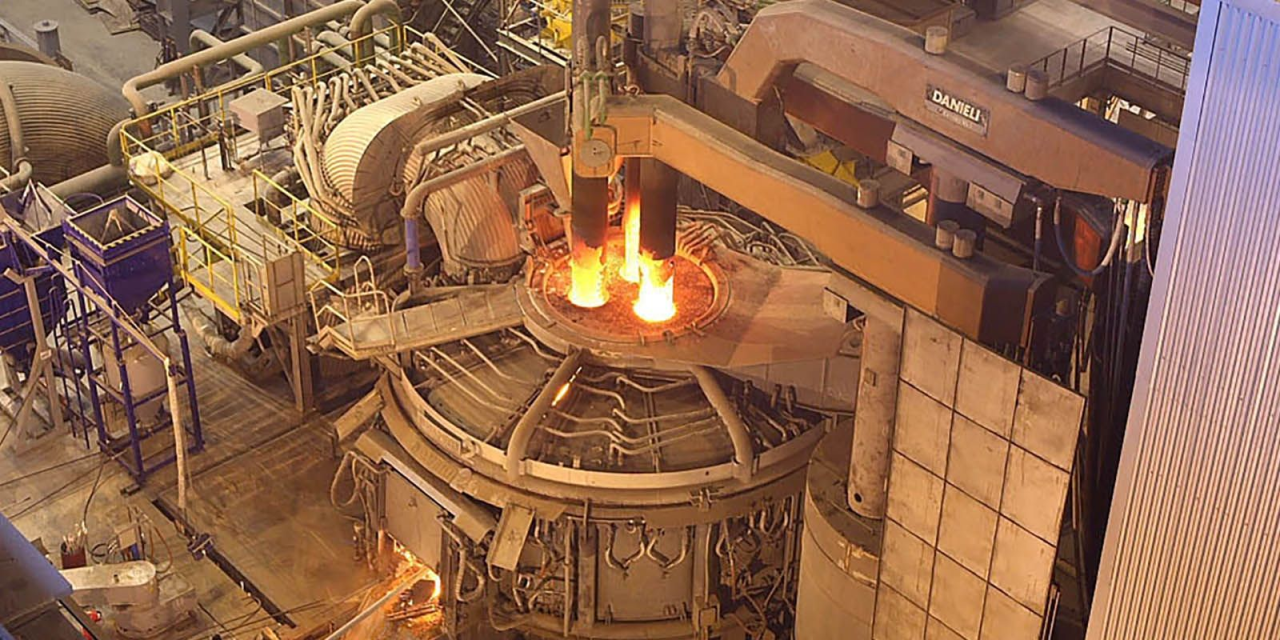

**Описание проблемы**

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Значительные траты энергии уходят на увеличение температуры расплава в ковше в процессе добавки ингидиентов в сплав для получения необходимых свойств стали. Процесс добавления - итеративный, в нем есть различные факторы влияющие на температуру предугадать которые сложно (например состояние электродов, качество руды, качество добавок и прочее). Предсказав температуру и проанализировав модель можно получить данные, которые помогут комбинату снизить энергопотребление.

**Цель**

Построить модель предсказывающую температуру стали в ковше. Выбранная метрика - MAE должна быть меньше 6.8 градусов цельсия.

# Описание технологического процесса

## Общая схема процесса 

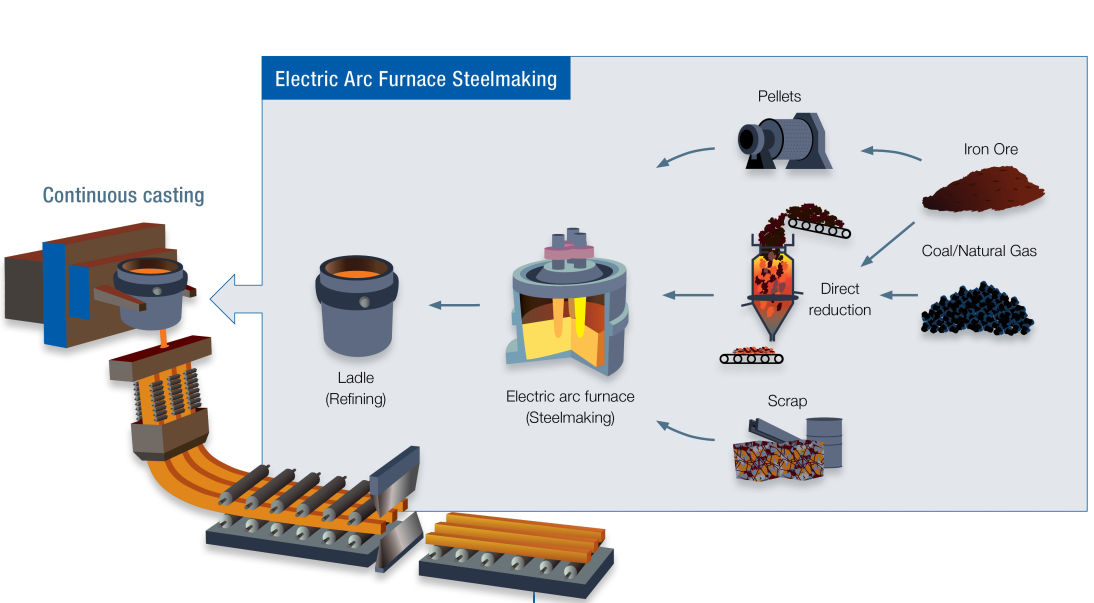

# Ковш и процесс 

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь (**На рисунке - Molten steel**) заливают в ковш  и подогревают до нужной температуры графитовыми электродами (**На рисунке - Grafite electrodes**). Они установлены в крышке ковша. 

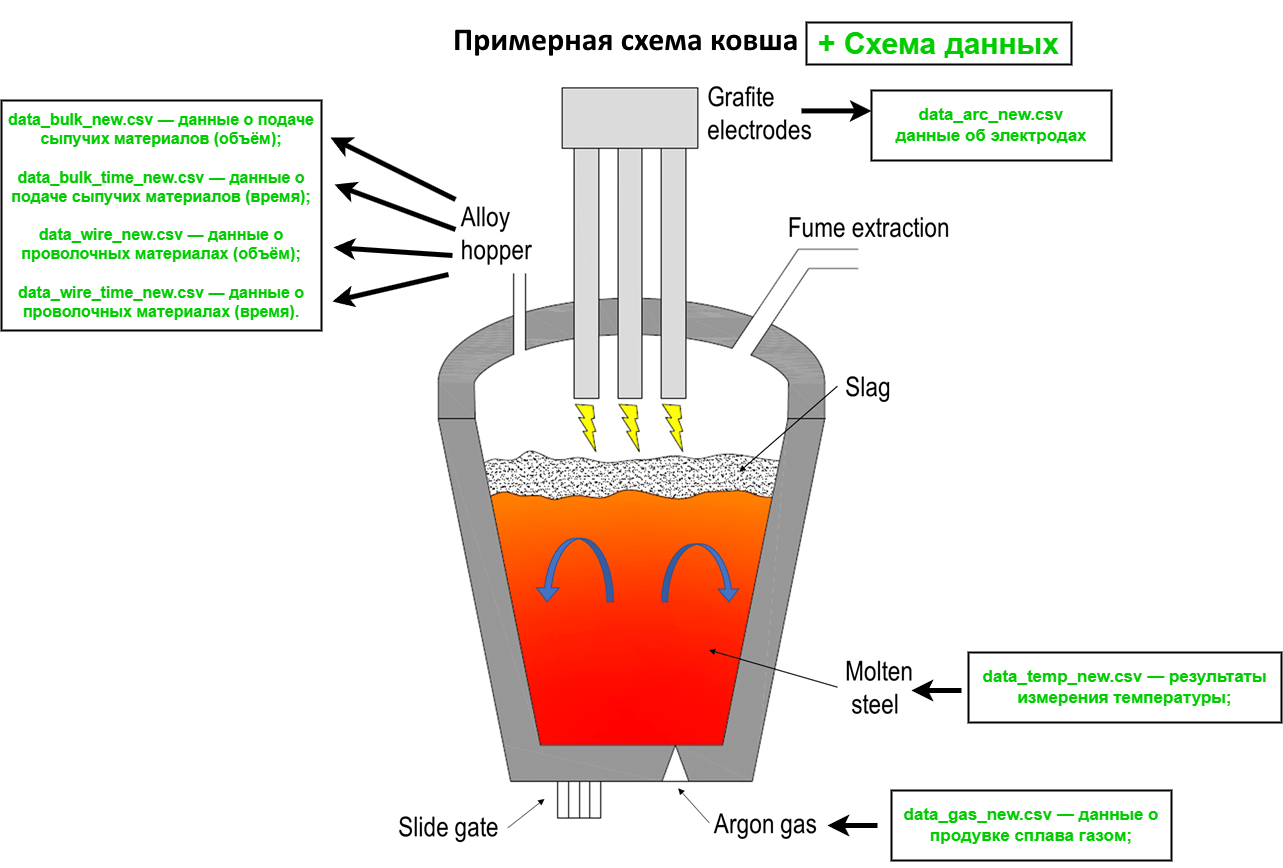

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава  из бункера для сыпучих материалов (**На рисунке - Alloy Hopper**) или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом (**На рисунке - Argon gas**). Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

*Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.*



## План работы

1. Проведу осмотр данных и определю
   - Выбросы/пропуски/нормальность распределения
   - Кластеризация температуры
2. Предобработка данных
   - убрать выбросы
   - удалить/заполнить пропуски.
3. Определить итоговый формат данных. Объединить таблицы по общему ключу key
4. Визуализировать итоговые данные, проверить на мультиколлинеарность
5. Разбить данные на выборки: 25% тест, 75% обучающие, random_state=030723
6. Обучить разные модели (линейные, лес, град. бустинг)
   - Подбор гиперпараметров автоматизированный 
   - Кросс-валидация
7. Сравнить модели
8. Выбрать лучшую, обучить, протестировать
9. Провести анализ модели
    - Анализ метрик
    - Анализ важности факторов (shap)
10. Составить результаты и план для дальнейшего улучшения модели

# Импорт библиотек

In [1]:
!pip -q install shap optuna 

In [2]:
# Pandas
import pandas as pd

# Seaborn
import seaborn as sns

# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    ElasticNet,
    Ridge
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# LightGMB
from lightgbm import LGBMRegressor

# Catboost
from catboost import CatBoostRegressor

# Time
import time

import optuna

# Shap
import shap

# Warnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Импорт данных

In [3]:
try:
    data_arc = pd.read_csv('C:\project_data\metal_energy\data_arc_new.csv')
    data_bulk = pd.read_csv('C:\project_data\metal_energy\data_bulk_new.csv')
    data_bulk_time = pd.read_csv('C:\project_data\metal_energy\data_bulk_time_new.csv')
    data_gas = pd.read_csv('C:\project_data\metal_energy\data_gas_new.csv')
    data_temp = pd.read_csv('C:\project_data\metal_energy\data_temp_new.csv')
    data_wire = pd.read_csv('C:\project_data\metal_energy\data_wire_new.csv')
    data_wire_time = pd.read_csv('C:\project_data\metal_energy\data_wire_time_new.csv')
except:
    data_arc = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')
    data_bulk = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')
    data_gas = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')
    data_temp = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')
    data_wire = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')    

Функции для описания данных

In [4]:
def data_analysis(data, data_desc):
    print(f'------------{data_desc}------------')
    print('Количество строк', data.shape[0])
    print('------------Три первых строки------------')
    display(data.head(3))
    print('------------Описательная статистика------------')
    display(data.describe())
    print('------------Пропуски------------')
    print(data.isna().sum())
    print('------------Типы данных------------')
    print(data.dtypes)

# Осмотр данных

## Сколько всего партий в данных?

In [5]:
print('Партии в данных об электродах', data_arc['key'].nunique())
print('Партии в данных о газе', data_gas['key'].nunique())
print('Партии в данных температуре', data_temp['key'].nunique())
print('Партии в данных объема сып. материалов', data_bulk['key'].nunique())
print('Партии в данных времени сып. материалов', data_bulk_time['key'].nunique())
print('Партии в данных объемах проволочных материалов', data_wire['key'].nunique())
print('Партии в данных времени проволочных материалов', data_wire_time['key'].nunique())

Партии в данных об электродах 3214
Партии в данных о газе 3239
Партии в данных температуре 3216
Партии в данных объема сып. материалов 3129
Партии в данных времени сып. материалов 3129
Партии в данных объемах проволочных материалов 3081
Партии в данных времени проволочных материалов 3081


## Данные об электродах

In [6]:
data_analysis(data_arc, 'Данные об электродах')

------------Данные об электродах------------
Количество строк 14876
------------Три первых строки------------


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460


------------Описательная статистика------------


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


------------Пропуски------------
key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64
------------Типы данных------------
key                       int64
Начало нагрева дугой     object
Конец нагрева дугой      object
Активная мощность       float64
Реактивная мощность     float64
dtype: object


In [7]:
electrode_working_time = data_arc['Конец нагрева дугой'].astype('datetime64[s]')-data_arc['Начало нагрева дугой'].astype('datetime64[s]')

Text(0.5, 1.0, 'Распределение времени работы электродов в секундах для каждого запуска')

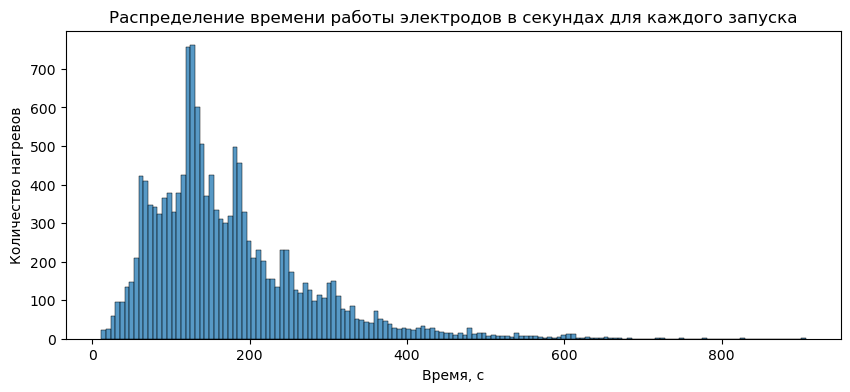

In [8]:
plt.figure(figsize=(10,4))
sns.histplot(electrode_working_time.dt.seconds, bins=150)
plt.xlabel('Время, с')
plt.ylabel('Количество нагревов')
plt.title('Распределение времени работы электродов в секундах для каждого запуска')

Text(0.5, 1.0, 'Распределение количества нагревов в партиях')

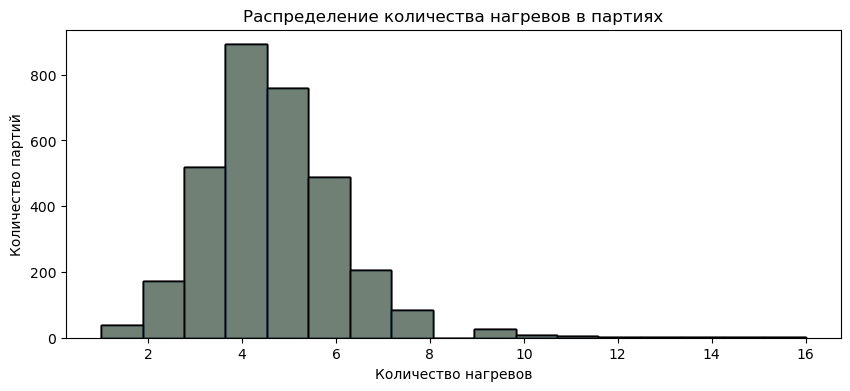

In [9]:
plt.figure(figsize=(10,4))
sns.histplot(data_arc.groupby(by='key').count(), bins=17, legend=False)
plt.xlabel('Количество нагревов')
plt.ylabel('Количество партий')
plt.title('Распределение количества нагревов в партиях')

Text(0.5, 1.0, 'Распределение активной мощности в нагреве')

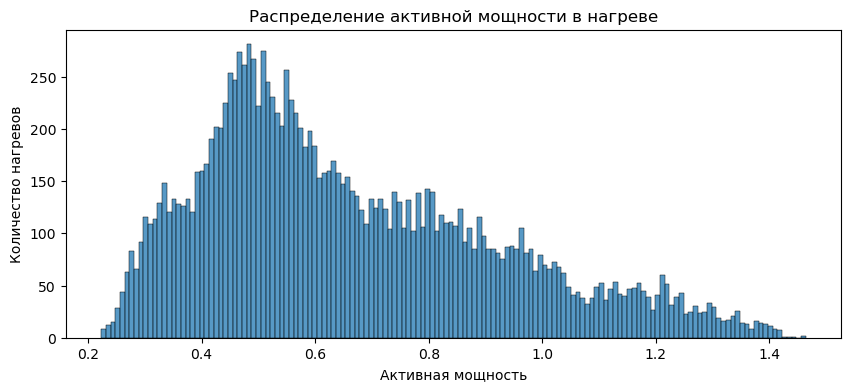

In [10]:
plt.figure(figsize=(10,4))
sns.histplot(data_arc['Активная мощность'], bins=150, legend=False)
plt.xlabel('Активная мощность')
plt.ylabel('Количество нагревов')
plt.title('Распределение активной мощности в нагреве')

1

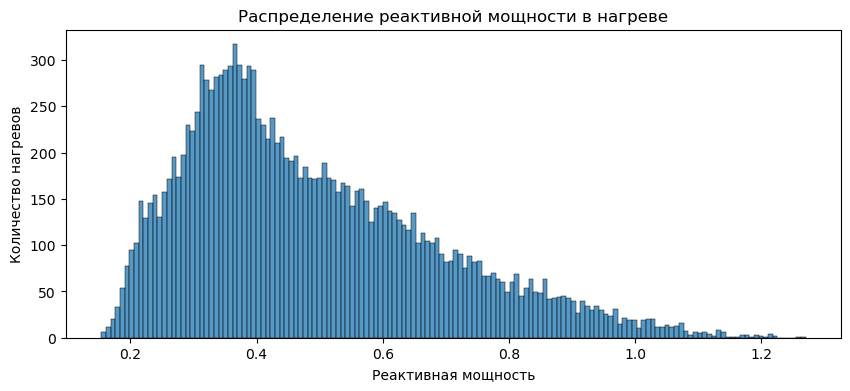

In [11]:
plt.figure(figsize=(10,4))
sns.histplot(data_arc['Реактивная мощность'][data_arc['Реактивная мощность']>0], bins=150, legend=False)
plt.xlabel('Реактивная мощность')
plt.ylabel('Количество нагревов')
plt.title('Распределение реактивной мощности в нагреве')

data_arc['Реактивная мощность'][data_arc['Реактивная мощность']<0].count()

## Данные о продувке сплава газом

In [12]:
data_analysis(data_gas, 'Данные о продувке сплава газом')

------------Данные о продувке сплава газом------------
Количество строк 3239
------------Три первых строки------------


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793


------------Описательная статистика------------


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


------------Пропуски------------
key      0
Газ 1    0
dtype: int64
------------Типы данных------------
key        int64
Газ 1    float64
dtype: object


Text(0.5, 1.0, 'Распределение объема подач газа')

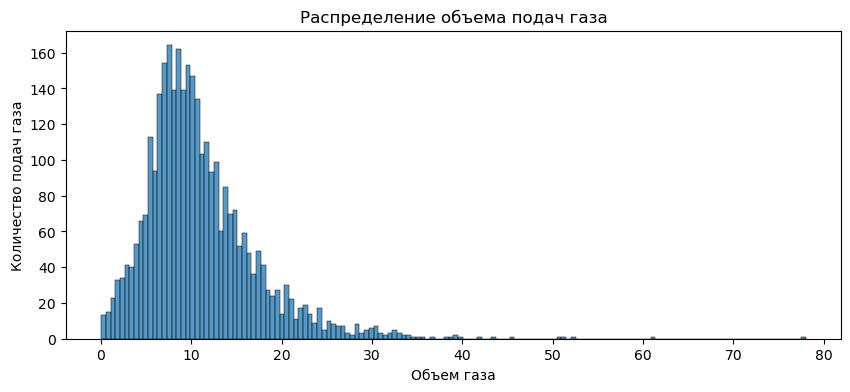

In [13]:
plt.figure(figsize=(10,4))
sns.histplot(data_gas['Газ 1'], bins=150, legend=False)
plt.xlabel('Объем газа')
plt.ylabel('Количество подач газа')
plt.title('Распределение объема подач газа')

## Данные - измерения температуры

In [14]:
data_analysis(data_temp, 'Результаты измерения температуры')

------------Результаты измерения температуры------------
Количество строк 18092
------------Три первых строки------------


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0


------------Описательная статистика------------


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


------------Пропуски------------
key                0
Время замера       0
Температура     3427
dtype: int64
------------Типы данных------------
key               int64
Время замера     object
Температура     float64
dtype: object


Пропуски температуры в партиях

In [15]:
data_temp['key'][data_temp['Температура'].isna()].nunique()

739

Text(0.5, 1.0, 'Распределение температур')

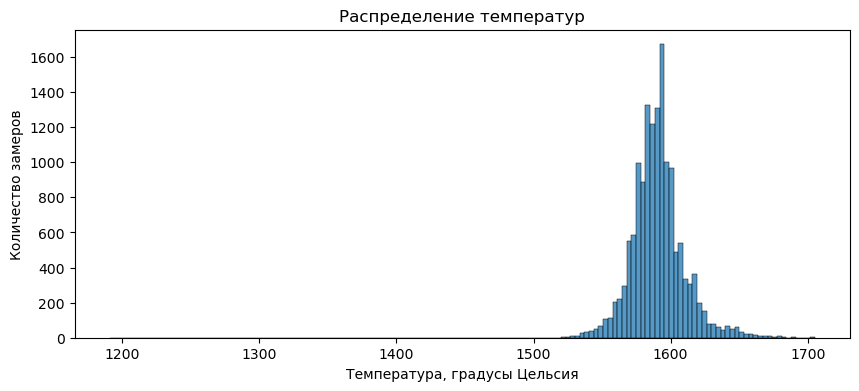

In [16]:
plt.figure(figsize=(10,4))
sns.histplot(data_temp['Температура'], bins=150, legend=False)
plt.xlabel('Температура, градусы Цельсия')
plt.ylabel('Количество замеров')
plt.title('Распределение температур')

## Данные о добавках в смесь сыпучих материалов (время и объемы)

In [17]:
data_analysis(data_bulk, 'Объем сыпучих материалов')

------------Объем сыпучих материалов------------
Количество строк 3129
------------Три первых строки------------


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0


------------Описательная статистика------------


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


------------Пропуски------------
key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64
------------Типы данных------------
key          int64
Bulk 1     float64
Bulk 2     float64
Bulk 3     float64
Bulk 4     float64
Bulk 5     float64
Bulk 6     float64
Bulk 7     float64
Bulk 8     float64
Bulk 9     float64
Bulk 10    float64
Bulk 11    float64
Bulk 12    float64
Bulk 13    float64
Bulk 14    float64
Bulk 15    float64
dtype: object


In [18]:
bulk_list = ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15']

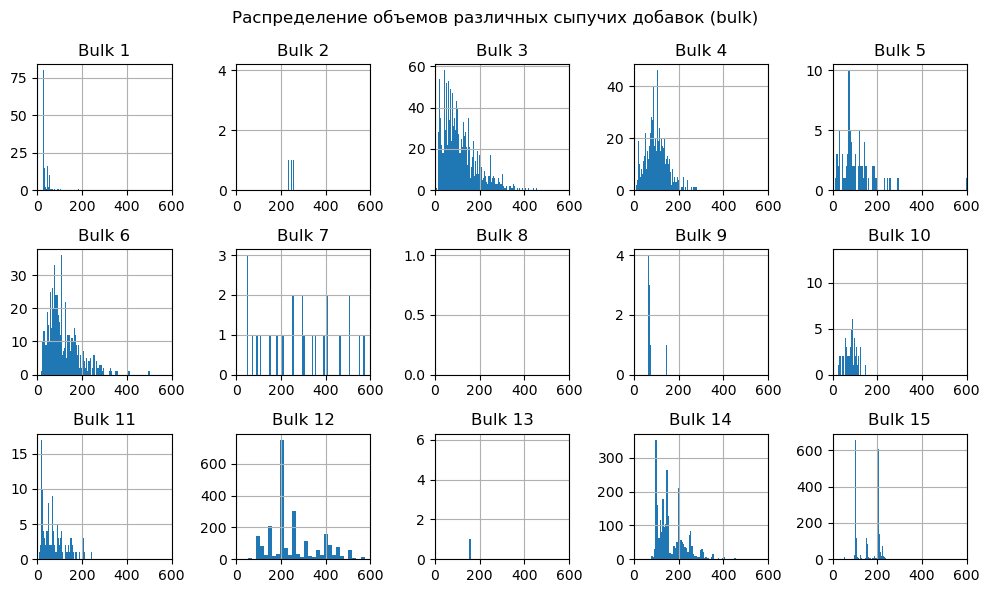

In [19]:
plt.figure(figsize=[10, 6])
plt.suptitle('Распределение объемов различных сыпучих добавок (bulk)')
for i, bulk in enumerate(bulk_list):
    plt.subplot(3, 5, i+1)
    data_bulk[bulk].hist(bins=100)
    plt.title(bulk)
    plt.xlim(0, 600)
    plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Распределение объема сыпучих добавок')

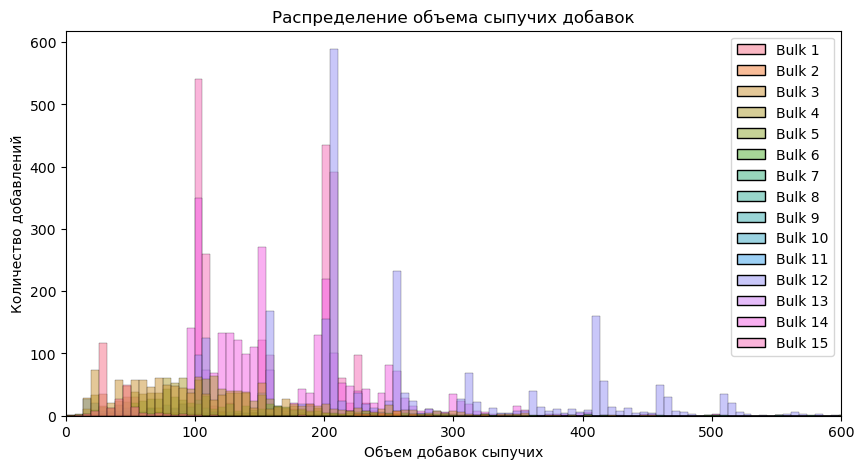

In [20]:
plt.figure(figsize=(10,5))
sns.histplot(data_bulk.drop('key', axis=1), bins=300)
plt.xlim(0, 600)
plt.xlabel('Объем добавок сыпучих')
plt.ylabel('Количество добавлений')
plt.title('Распределение объема сыпучих добавок')

In [21]:
data_analysis(data_bulk_time, 'Cыпучие материалы - время')

------------Cыпучие материалы - время------------
Количество строк 3129
------------Три первых строки------------


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16


------------Описательная статистика------------


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


------------Пропуски------------
key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64
------------Типы данных------------
key         int64
Bulk 1     object
Bulk 2     object
Bulk 3     object
Bulk 4     object
Bulk 5     object
Bulk 6     object
Bulk 7     object
Bulk 8     object
Bulk 9     object
Bulk 10    object
Bulk 11    object
Bulk 12    object
Bulk 13    object
Bulk 14    object
Bulk 15    object
dtype: object


## Данные о добавках в смесь проволочных материалов (время и объемы)

In [22]:
data_analysis(data_wire, 'Объем проволочных материалов')

------------Объем проволочных материалов------------
Количество строк 3081
------------Три первых строки------------


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


------------Описательная статистика------------


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


------------Пропуски------------
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
------------Типы данных------------
key         int64
Wire 1    float64
Wire 2    float64
Wire 3    float64
Wire 4    float64
Wire 5    float64
Wire 6    float64
Wire 7    float64
Wire 8    float64
Wire 9    float64
dtype: object


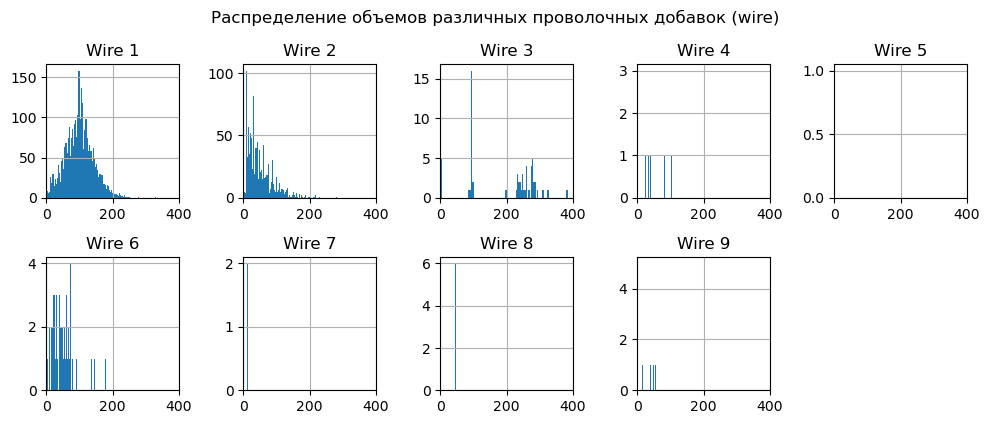

In [23]:
wire_list = ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9']

plt.figure(figsize=[10, 6])
plt.suptitle('Распределение объемов различных проволочных добавок (wire)')
for i, wire in enumerate(wire_list):
    plt.subplot(3, 5, i+1)
    data_wire[wire].hist(bins=100)
    plt.title(wire)
    plt.xlim(0, 400)
    plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Распределение объема сыпучих добавок')

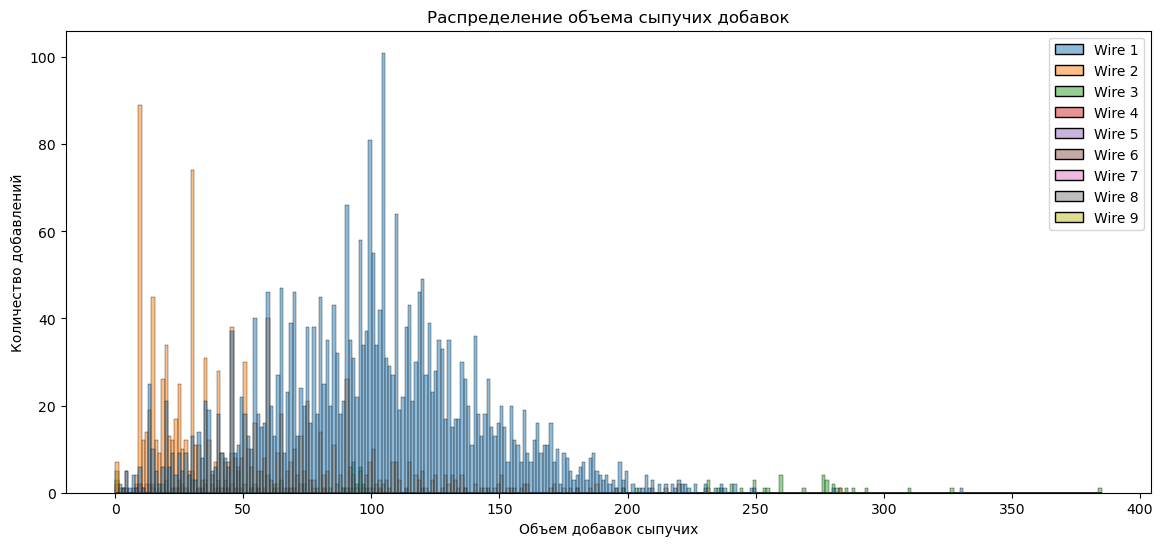

In [24]:
plt.figure(figsize=(14,6))
sns.histplot(data_wire.drop('key', axis=1), bins=300)
#plt.xlim(0, 600)
plt.xlabel('Объем добавок сыпучих')
plt.ylabel('Количество добавлений')
plt.title('Распределение объема сыпучих добавок')

In [25]:
data_analysis(data_wire_time, 'Проволочные материалы - время')

------------Проволочные материалы - время------------
Количество строк 3081
------------Три первых строки------------


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


------------Описательная статистика------------


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


------------Пропуски------------
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
------------Типы данных------------
key        int64
Wire 1    object
Wire 2    object
Wire 3    object
Wire 4    object
Wire 5    object
Wire 6    object
Wire 7    object
Wire 8    object
Wire 9    object
dtype: object


<style>
    .bordered-cell {
        border: 3px solid black;
        padding: 10px;
    }
</style>

<div class="bordered-cell">

<font size=5>**Вывод и план по подготовке данных**</font>

Данные в целом:

1. Количество партий в данных разное
   - *Решение* - выбрать партии которые совпадают в данных
2. Данные о температуре - пропуски в партиях, если выкинуть эти строки то целостность процесса пострадает, либо убирать целиком партии, то датасет уменьшиться примерно на четверть.
   - *Решение* - заполнить через ffill, либо средней между двумя точками во времени. Как другой вариант - удалить, возможно данных будет достаточно.
3. Данные о добавках. Их добавляют в разных количествах и соотношениях, вероятно зависит от процесса. Может пропуски заменить на ноль?

Данные об электродах:

1. Время (2-4 минуты обычно) и количество нагревов (2-8 запусков электродов) распределены нормально, но есть выбросы
2. Активная и реактивная мощности распределены нормально, со смещением. Есть выброс

Данные о газе:

1. Объемы газа распределены нормально, но есть подачи с очень высоким значением.
2. Пропусков нет

Данные о температуре:

1. Распределение нормальное. Но температура иногда падает процентов на 20% от средней. Интересно как это влияет на сплав?
2. Пропуски в температуре, в 739 партиях

Данные о добавках:

1. И проволчные и сыпучие ингридиенты добавляют в разных количествах, без расшифровки названия добавки не ясна цель её

# Подготовка данных

**Температура**

- Нужна только температура начальная и конечная. Создам таблицу содержащую начальную, конечную температуры, ключ, общее время нагрева

In [26]:
# функция для получения новой таблицы температур
def prepare_temp(data_temp):
    # списки для формирования новой таблицы
    start_temp = []
    end_temp = []
    time_diff = []
    keys = []

    for key in data_temp['key'].unique():
        
        # временная таблица для каждого ключа
        temporal_table = data_temp[data_temp['key'] == key]
        temporal_table['Время замера'] = pd.to_datetime(temporal_table['Время замера'])
        temporal_table = temporal_table.sort_values(by='Время замера')
        
        # Собираю значения из временной таблицы
        start_temp.append(temporal_table['Температура'].iloc[0])
        end_temp.append(temporal_table['Температура'].iloc[-1])
        time_diff.append((temporal_table['Время замера'].iloc[-1] - temporal_table['Время замера'].iloc[0]).seconds)
        keys.append(key)

    # формирую новую таблицу и убираю пропуски    
    table = pd.DataFrame({'start temp' : start_temp, 'end temp' : end_temp, 'time': time_diff}, index=keys)
    table = table[table['start temp']>1500]
    table = table[table['end temp']>1500]
    table = table.dropna()
    
    return table


**Материалы**

функция для сводных таблиц по ключу с суммированием и дальнешее объединение таблиц

In [27]:
# возвращает объединенную таблицу wire+bulk
def prepare_bulk_wire(bulk, wire):
    bulk = data_bulk.pivot_table(index='key', aggfunc='sum')
    wire = data_wire.pivot_table(index='key', aggfunc='sum')
    table = pd.concat([bulk, wire], axis=1, join='inner')
    table = table.fillna(0)
    return table

**Нагрев**

Функция для создания таблицы с суммами мощностей, временем нагрева

In [28]:
# функция для получения новой таблицы нагрева
def prepare_arc(data_arc):
    # списки для формирования новой таблицы
    active = []
    reactive = []
    time_diff = []
    keys = []
    
    # Убираю выброс
    data_arc = data_arc[data_arc['Реактивная мощность']>0]

    for key in data_arc['key'].unique():
        
        # временная таблица для каждого ключа
        temporal_table = data_arc[data_arc['key'] == key]
        temporal_table['Начало нагрева дугой'] = pd.to_datetime(temporal_table['Начало нагрева дугой'])
        temporal_table['Конец нагрева дугой'] = pd.to_datetime(temporal_table['Конец нагрева дугой'])
        
        # Собираю значения из временной таблицы
        active.append(temporal_table['Активная мощность'].sum())
        reactive.append(temporal_table['Реактивная мощность'].sum())
        time_diff.append((temporal_table['Конец нагрева дугой'] - temporal_table['Начало нагрева дугой']).dt.seconds.sum())
        keys.append(key)

    # формирую новую таблицу и убираю пропуски    
    table = pd.DataFrame({'active_sum' : active, 'reactive_sum' : reactive, 'time_heating': time_diff}, index=keys)
    table = table.dropna()
    return table

**Газ**

In [29]:
def prepare_gas(data_gas):
    table = pd.DataFrame({'gas' : data_gas['Газ 1']}, index=data_gas['key'])
    return table

# Объединение таблиц и финальный анализ

<style>
    .bordered-cell {
        border: 3px solid black;
        padding: 10px;
    }
</style>

<div class="bordered-cell">

<font size=5>**Итоговый формат данных**</font>


Объект - ковш. В строке будут данные описывающие его состояние до добавок/нагревов - это начальная температура.  Добавки, нагревы, энергию - суммирую в признаки ковша. Целевой признак - конечная температура ковша.

В признаках объекта:
1. Температура изначальная
2. Температура конечная
3. Сумарная мощность
4. Время от начала и до конца измерений
5. Сумарное время нагрева
5. Добавки в виде суммы для каждой добавки в каждой партии (9 столбцов для проволки и 15 для сыпучих)

In [30]:
temp = prepare_temp(data_temp)
arc = prepare_arc(data_arc)
bulk_wire = prepare_bulk_wire(data_bulk, data_wire)
gas = prepare_gas(data_gas)

In [31]:
all_data = pd.concat([temp, arc, bulk_wire, gas], axis=1, join='inner')

In [32]:
all_data.head(3)

,start temp,end temp,time,active_sum,reactive_sum,time_heating,Bulk 1,Bulk 10,Bulk 11,Bulk 12,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,gas
1,1571.0,1613.0,1714,3.036730,2.142821,1098,0.0,0.0,0.0,206.0,...,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,1581.0,1602.0,1265,2.139408,1.453357,811,0.0,0.0,0.0,206.0,...,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,1596.0,1599.0,1753,4.063641,2.937457,655,0.0,0.0,0.0,205.0,...,91.160157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219


Корреляция

In [33]:
all_data.corr().abs().unstack().sort_values(ascending=False).drop_duplicates().head(10)

start temp    start temp      1.000000
active_sum    reactive_sum    0.992416
Bulk 9        Wire 8          0.974968
Bulk 7        Wire 4          0.740570
time_heating  active_sum      0.720854
reactive_sum  time_heating    0.713082
Wire 4        Bulk 2          0.699340
Bulk 2        Bulk 7          0.679353
Bulk 15       Bulk 12         0.614182
Wire 4        Wire 7          0.602964
dtype: float64

<style>
    .bordered-cell {
        border: 3px solid black;
        padding: 10px;
    }
</style>

<div class="bordered-cell">

<font size=5>**Корреляции**</font>

Существует сильная корреляция между:
- суммами мощностей
- ингридиентами Bulk 9, Wire 8

Wire 5 - пустые значения

**Итог**: Удалю реактивную мощность, Wire 8, Wire 5

In [34]:
all_data = all_data.drop(['reactive_sum', 'Wire 5', 'Wire 8'], axis=1)

# Деление, масштабирование

Делю

In [35]:
train, test = train_test_split(all_data, test_size=0.25, random_state=30723)

X = train.drop('end temp', axis=1)
y = train['end temp']
X_test = test.drop('end temp', axis=1)
y_test = test['end temp']

Масштабирую

In [36]:
features_columns = X.columns

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_test = scaler.transform(X_test)

# Обучение и сбор метрик моделей

In [37]:
results = {}
best_parameters = {}

Функция для оценки моделей, на выходе функции добавлюя в словари метрики и параметры модели

In [38]:
def model_eval(model_name, model, parameters):

    # Параметры для скоринга и кросс-валидации
    scoring = {'RMSE':'neg_root_mean_squared_error', "R2" : "r2", 'MAE' : 'neg_mean_absolute_error'}

    # Гридсерч
    grid_search_model = GridSearchCV(model, parameters, cv=4, scoring=scoring, n_jobs=-1, refit="MAE")
    grid_search_model.fit(X, y)
    
    # Сохраняю метрики лучшей модели
    RMSE = -grid_search_model.cv_results_['mean_test_RMSE'][grid_search_model.best_index_]
    MAE = -grid_search_model.best_score_
    R2 = grid_search_model.cv_results_['mean_test_R2'][grid_search_model.best_index_]

    """ # Вывод на экран метрик
    print('Метрики для модели', model_name)
    print('RMSE =', RMSE)
    print('MAE =', MAE)
    print('R2 =', R2)
    print('Best parameters', grid_search_model.best_params_) """

    # Время предсказания
    start_time = time.time()
    grid_search_model.predict(X)
    predict_time = time.time() - start_time
    
    # Сохраняю в общую таблицу метрики для модели
    results[model_name] = [MAE, RMSE, R2, predict_time]
    best_parameters[model_name] = grid_search_model.best_params_


Линейная регрессия

In [39]:
scoring = {'RMSE':'neg_root_mean_squared_error', "R2" : "r2", 'MAE' : 'neg_mean_absolute_error'}
model = LinearRegression()
scores = cross_validate(model, X, y, cv=4,
                         scoring=scoring)
results['LinearRegression'] = [-scores['test_MAE'].mean(), -scores['test_RMSE'].mean(), scores['test_R2'].mean(), scores['score_time'].mean()]

ElasticNet

In [40]:
parameters = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
model_eval('ElasticNet', ElasticNet(random_state=30723), parameters)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Lasso

In [41]:
parameters = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
model_eval('Lasso', Lasso(random_state=30723), parameters)

Ridge

In [42]:
parameters = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
model_eval('Ridge', Ridge(random_state=30723), parameters)

Случайный лес

In [43]:
parameters = {"n_estimators": [1, 10, 100, 500],
              "max_depth": [2, 4, 6, 8, 10]}
model_eval('Случайный лес',
               RandomForestRegressor(random_state=30723), parameters)

LGBM

In [44]:
parameters = {'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5]}
model_eval('LGBMRegressor', LGBMRegressor(random_state=30723), parameters)

Catboost

In [45]:
parameters = {'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5]}
model_eval('Catboost', CatBoostRegressor(random_state=30723,
    logging_level='Silent'), parameters)

Catboost optuna

In [46]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    mae = mean_absolute_error(y_val, predictions)
    return mae

In [48]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000, timeout=600)

In [49]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.03817607761940198, 'depth': 4, 'subsample': 0.2271238898169484, 'colsample_bylevel': 0.8189208230269731, 'min_data_in_leaf': 46}
Best RMSE: 5.676731278467019


In [50]:
optuna.visualization.plot_optimization_history(study)

In [51]:
optuna.visualization.plot_slice(study)

In [52]:
results['catboost_optuna'] = [study.best_value, None, None, None]

# Сравнение моделей

In [53]:
results_df = pd.DataFrame(results, index=['MAE', 'RMSE', 'R2', 'Predict_time'])

In [54]:
pd.options.display.float_format = '{:.3f}'.format
display(results_df.T.sort_values(by='MAE'))

,MAE,RMSE,R2,Predict_time
catboost_optuna,5.677,NaN,NaN,NaN
Catboost,5.947,8.062,0.464,0.009
Lasso,6.050,8.125,0.455,0.001
LGBMRegressor,6.084,8.313,0.430,0.006
ElasticNet,6.095,8.224,0.443,0.010
Ridge,6.122,8.558,0.391,0.000
LinearRegression,6.141,8.747,0.358,0.003
Случайный лес,6.175,8.396,0.419,0.145


<style>
    .bordered-cell {
        border: 3px solid black;
        padding: 10px;
    }
</style>

<div class="bordered-cell">

<font size=5>**Результат сравнения моделей**</font>
    
- Получены метрики с 7 различных моделей, + модель catboost с поиском гиперпаратров optuna
- MAE моделей близки друг к другу, но лучший результат по МАЕ показал оптимизированный catboost
- Оптимизированный catboost c полученными гиперпараметрами пойдет дальше в работу
- По скорости предсказания модели сильно не отличаются, кроме случайного леса. В этой модели скорость отличалась на один-два порядка в худшую сторону.

# Обучение итоговой модели

In [61]:
study.best_params

{'learning_rate': 0.03817607761940198,
 'depth': 4,
 'subsample': 0.2271238898169484,
 'colsample_bylevel': 0.8189208230269731,
 'min_data_in_leaf': 46}

In [56]:
model = CatBoostRegressor(**study.best_params, verbose=200)
model.fit(X, y)

0:	learn: 10.9864246	total: 1.22ms	remaining: 1.22s
200:	learn: 7.5947545	total: 196ms	remaining: 780ms
400:	learn: 6.7281433	total: 420ms	remaining: 627ms
600:	learn: 6.2738243	total: 637ms	remaining: 423ms
800:	learn: 5.9303176	total: 853ms	remaining: 212ms
999:	learn: 5.6581411	total: 1.07s	remaining: 0us


# Анализ итоговой модели

In [57]:
y_pred = model.predict(X_test)

print('MAE итоговой модели равно', mean_absolute_error(y_pred, y_test).round(2), 'градусов Цельсия')

MAE итоговой модели равно 5.52 градусов Цельсия


In [58]:
importances = model.feature_importances_
feature_importance = pd.DataFrame({'importance':importances,'features':features_columns}).sort_values('importance', ascending=False).reset_index(drop=True)
feature_importance.head(10)

,importance,features
0,25.152,start temp
1,24.006,time_heating
2,10.279,time
3,7.036,Wire 1
4,4.662,Bulk 6
5,3.685,Bulk 12
6,3.522,Bulk 14
7,3.444,Wire 2
8,3.442,Bulk 15
9,2.821,Bulk 1


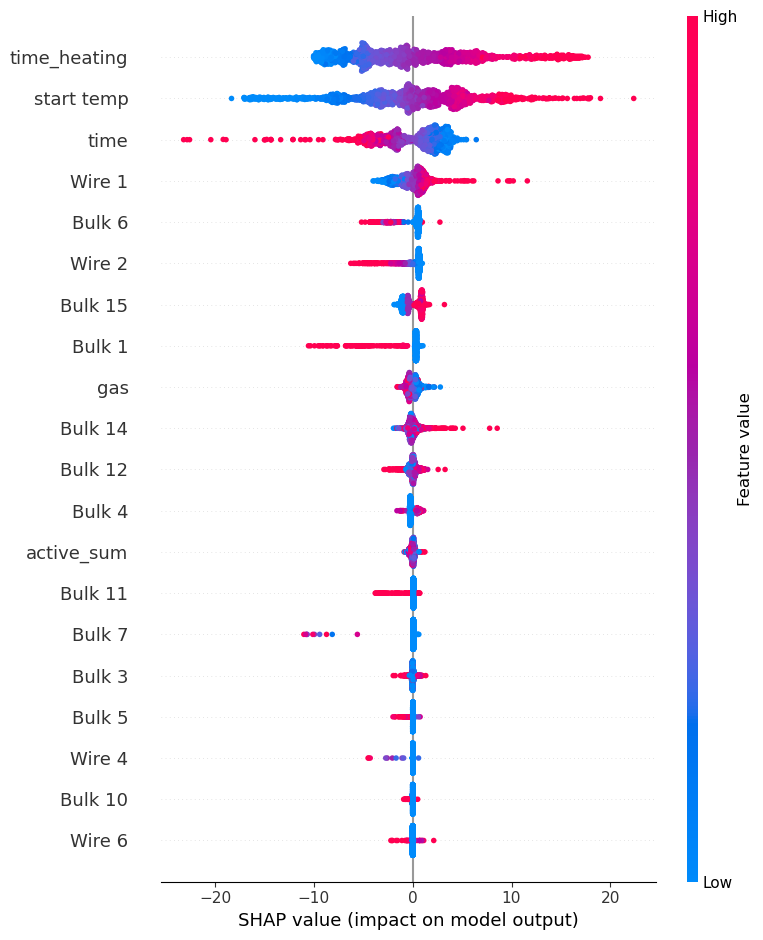

In [59]:
tree_explainer = shap.TreeExplainer(model)
shap_values = tree_explainer.shap_values(X)
shap.summary_plot(shap_values, X, feature_names=features_columns)

Пример (второй объект из тренировочных данных) влияния признаков на предсказание модели

In [60]:
shap.initjs()
shap_values = tree_explainer.shap_values(X)

# visualize the first prediction's explanation
shap.force_plot(tree_explainer.expected_value, shap_values[1,:], X[1,:], feature_names=features_columns)

<style>
    .bordered-cell {
        border: 3px solid black;
        padding: 10px;
    }
</style>

<div class="bordered-cell">

<font size=5>**Результат анализа модели**</font>

**Модель:**
    
- В результате получена модель на основе CatboostRegressor, метрика модели на тестовом датасете МАЕ равна 5.52 градусов
    
**Признаки:**

- Добавка наиболее влияющая на температуру - Wire 1, интересно что в ней. Её и добавлют больше и чаще чем остальных. Может это углерод, как самая необходимая добавка в стали? Но почему он в проволке?
- Далее по важности из добавок - Bulk 6.
- Bulk 8 и Wire 9 - сильно коррелируют, вероятно это ингридиенты соотношение которых нужно очень точно соблюдать

**Какие выводы можно сделать из SHAP (SHapley Additive exPlanations)?**

- Time - общее время измерений температур. Чем больше это общее время, тем ниже конечная температура.
- Начальная температура и общее время нагрева наиболее значимы в данной модели, и увеличивают конечную температуру.
- С добавками картина интересная. Часть добавок увеличивают конечную температуру (Wire 1, Bulk 4,12,14) либо уменьшают (Bulk 6, 15)
- Увеличенные объемы газа - охлаждают ковш
- Сумма мощностей мало влияет на предсказание модели, как и некоторые другие добавки (например Wire 7)



# Отчёт

<style>
    .bordered-cell {
        border: 3px solid black;
        padding: 10px;
    }
</style>

<div class="bordered-cell">

1. План работы выполнен полностью
2. Основная проблема была в понимании смысла модели и для какой цели/задач она нужна бизнесу. Решилось на встрече при обсуждении.
3. Ключевые шаги:
    - Понять в чем смысл модели
    - Для достижения цели составить себе список задач
    - Предобработка данных
    - Анализ мультиколлинеарности признаков и масштабирование
    - Обучение и сравнение разных моделей
    - Выбор итоговой модели, подбор гиперпараметров
    - Анализ результатов итоговой модели: метрика, важность признаков в модели, примеры работы модели на объектах
4. В результате получена модель на основе CatboostRegressor, метрика модели на тестовом датасете МАЕ равна 5.52 градусов
5. Признаки используемые в модели (объект - ковш, поэтому в данных агрегировались значения для ковша):
    - Начальная температура сплава в ковше
    - Конечная температура сплава в ковше
    - Суммарная длительность измерения времени
    - Суммарная длительность работы электродов
    - Суммарная активная мощность
    - Значения сумм для каждой добавки отдельно
    - Признаки 'reactive_sum', 'Wire 5', 'Wire 8' - имели сильную корреляцию с другими признаками, удалил их
6. Гиперпараметры {'learning_rate': 0.042546607222914444, 'depth': 5, 'subsample': 0.21435221598889664, 'colsample_bylevel': 0.707551280024054, 'min_data_in_leaf': 24}
7. Для развития модели в дальнейшем:
    - Необходима связь с техническим специалистом предприятия
    - Нужно больше признаков: 
        1. итоговый вид сплава
        2. вид ковша
        3. состояние футеровки
        4. состояние электродов
        5. оценки качества руды
        6. подробное описание добавок
        7. больше объектов
    - Как будут получены такие данные, можно лучше оценить целесообрать признаков текущих в модели, обучить её еще раз и сравнить с предыдущей
    - Сделать отдельные модели под каждый сплав
    - Ввести в модель номер бригады которая работает, так можно оценить влияние конкретной бригады на итоговое состояние
    - Сформировать модель классификации для получения факта отхода от предсказанных температур в виде оповещения
    - Самый важный признак - исходная температура, наверно есть возможность моделировать и предшествующий процесс, сделать из него выводы
    - Построенная модель является основанием для работы в различных направления (оценка качества бригад, качества руды, качества электродов и т.д) либо для моделирования температур отдельных сплавов и/или всего процесса в целом